In [1]:
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
import shap

In [2]:
X_raw, Y = shap.datasets.adult()

In [3]:
A = X_raw[['Sex','Race']]
X = X_raw.drop(labels=['Sex', 'Race'],axis = 1)
X = pd.get_dummies(X)

In [4]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(X_scaled, 
                                                    Y, 
                                                    A,
                                                    test_size = 0.2,
                                                    random_state=0,
                                                    stratify=Y)

# Work around indexing issue
X_train = X_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

# Improve labels
A_test.Sex.loc[(A_test['Sex'] == 0)] = 'female'
A_test.Sex.loc[(A_test['Sex'] == 1)] = 'male'


A_test.Race.loc[(A_test['Race'] == 0)] = 'Amer-Indian-Eskimo'
A_test.Race.loc[(A_test['Race'] == 1)] = 'Asian-Pac-Islander'
A_test.Race.loc[(A_test['Race'] == 2)] = 'Black'
A_test.Race.loc[(A_test['Race'] == 3)] = 'Other'
A_test.Race.loc[(A_test['Race'] == 4)] = 'White'

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

In [6]:
lr_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)

lr_predictor.fit(X_train, Y_train)
Y_pred_lr = lr_predictor.predict(X_test)

In [7]:
svm_predictor = svm.SVC()

svm_predictor.fit(X_train, Y_train)
Y_pred_svm = svm_predictor.predict(X_test)

# Sample APIs

In [8]:
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
from fairlearn.metrics import group_summary, make_derived_metric, difference_from_summary, make_metric_group_summary
from fairlearn.metrics import demographic_parity_difference, balanced_accuracy_score_group_min
from fairlearn.metrics import false_negative_rate, false_positive_rate

## Report one disaggregated metric in a data frame

In [9]:
# Current
bunch = group_summary(accuracy_score, Y_test, Y_pred_lr, sensitive_features=A_test['Race'])
frame = pd.Series(bunch.by_group)
frame_o = pd.Series({**bunch.by_group, 'overall': bunch.overall})
print(frame)
print("=======================")
print(frame_o)

Amer-Indian-Eskimo    0.923077
Asian-Pac-Islander    0.840796
Black                 0.914826
Other                 0.851064
White                 0.826492
dtype: float64
Amer-Indian-Eskimo    0.923077
Asian-Pac-Islander    0.840796
Black                 0.914826
Other                 0.851064
White                 0.826492
overall               0.836481
dtype: float64


In [ ]:
# Proposed
result = GroupedMetric(accuracy_score, Y_test, Y_pred_lr, sensitive_features=A_test['Race'])
frame = result.by_group
frame_o = result.to_df() # Throw if there is a group called 'overall'

## Report several disaggregated metrics in a data frame.

In [10]:
# Current
bunch1 = group_summary(accuracy_score, Y_test, Y_pred_lr, sensitive_features=A_test['Race'])
bunch2 = group_summary(f1_score, Y_test, Y_pred_lr, sensitive_features=A_test['Race'])
frame = pd.DataFrame({
   'accuracy': bunch1.by_group, 'f1': bunch2.by_group})
frame_o = pd.DataFrame({
   'accuracy': {**bunch1.by_group, 'overall': bunch1.overall},
   'f1': {**bunch2.by_group, 'overall': bunch2.overall}})

print(frame)
print("=======================")
print(frame_o)

                    accuracy        f1
Amer-Indian-Eskimo  0.923077  0.666667
Asian-Pac-Islander  0.840796  0.652174
Black               0.914826  0.550000
Other               0.851064  0.000000
White               0.826492  0.612800
                    accuracy        f1
Amer-Indian-Eskimo  0.923077  0.666667
Asian-Pac-Islander  0.840796  0.652174
Black               0.914826  0.550000
Other               0.851064  0.000000
White               0.826492  0.612800
overall             0.836481  0.610033


In [ ]:
# Proposed
result = GroupedMetric({ 'accuracy':accuracy_score, 'f1':f1_score}, Y_test, Y_pred_lr, sensitive_features=A_test['Race'])
frame = result.by_group
frame_o = result.to_df() # Throw if there is a group called 'overall'

## Report metrics for intersecting sensitive features

In [11]:
# Current
sf = A_test['Race']+'-'+A_test['Sex'] # User builds new column manually

bunch = group_summary(accuracy_score, Y_test, Y_pred_lr, sensitive_features=sf)
frame = pd.Series(bunch.by_group)
frame_o = pd.Series({**bunch.by_group, 'overall': bunch.overall})

print(frame)
print("=======================")
print(frame_o)

Amer-Indian-Eskimo-female    0.937500
Amer-Indian-Eskimo-male      0.916667
Asian-Pac-Islander-female    0.879310
Asian-Pac-Islander-male      0.825175
Black-female                 0.962382
Black-male                   0.866667
Other-female                 0.909091
Other-male                   0.833333
White-female                 0.917824
White-male                   0.785510
dtype: float64
Amer-Indian-Eskimo-female    0.937500
Amer-Indian-Eskimo-male      0.916667
Asian-Pac-Islander-female    0.879310
Asian-Pac-Islander-male      0.825175
Black-female                 0.962382
Black-male                   0.866667
Other-female                 0.909091
Other-male                   0.833333
White-female                 0.917824
White-male                   0.785510
overall                      0.836481
dtype: float64


In [ ]:
# Proposed
result = GroupedMetric(accuracy_score, Y_test, Y_pred_lr, sensitive_features=[A['Race'], A['Sex']])
frame = result.by_group # Will have a MultiIndex built from the two sensitive feature columns
frame_o = result.to_def() # Not sure how to handle adding the extra 'overall' row

## Report several performance and fairness metrics of several models in a data frame

In [12]:
# Current
fb_s = lambda y_t, y_p: fbeta_score(y_t, y_p, beta=0.5)
custom_difference1 = make_derived_metric(
    difference_from_summary,
    make_metric_group_summary(fb_s))

def custom_difference2(y_true, y_pred, sensitive_features):
    bunch = group_summary(fbeta_score, y_true, y_pred, sensitive_features=sensitive_features, beta=0.5)
    frame = pd.Series(bunch.by_group)
    return (frame-frame['White']).min()

fairness_metrics = {
    'Custom difference 1': custom_difference1,
    'Custom difference 2': custom_difference2,
    'Demographic parity difference': demographic_parity_difference,
    'Worst-case balanced accuracy': balanced_accuracy_score_group_min}
performance_metrics = {
    'FPR': false_positive_rate,
    'FNR': false_negative_rate}
predictions_by_estimator = {
    'logreg': Y_pred_lr,
    'svm': Y_pred_svm}

df = pd.DataFrame()
for pred_key, y_pred in predictions_by_estimator.items():
    for fairm_key, fairm in fairness_metrics.items():
        df.loc[fairm_key, pred_key] = fairm(Y_test, y_pred, sensitive_features=A_test['Race'])
    for perfm_key, perfm in performance_metrics.items():
        df.loc[perfm_key, pred_key] = perfm(Y_test, y_pred)
        
print(df)

                                 logreg       svm
Custom difference 1            0.688073  0.769231
Custom difference 2           -0.673229 -0.704020
Demographic parity difference  0.166402  0.196253
Worst-case balanced accuracy   0.476190  0.476190
FPR                            0.066734  0.054803
FNR                            0.468750  0.462372


In [ ]:
# Proposed
custom_difference1 = make_derived_metric('difference', fbeta_score, parms={'beta', 0.5})

def custom_difference2(y_true, y_pred, sensitive_features):
    tmp = GroupedMetric(fbeta_score, y_true, y_pred, sensitive_features=sensitive_features, parms={'beta':0.5})
    return tmp.differences(relative_to='group', group='White', aggregate='min')

# The remainder as before

## Create a fairness-performance raster plot of several models

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

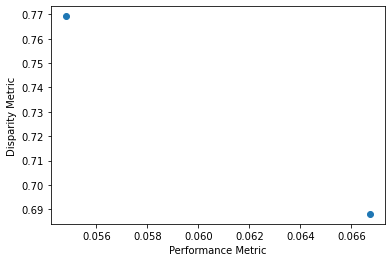

In [14]:
# Current
my_disparity_metric=custom_difference1
my_performance_metric=false_positive_rate

xs = [my_performance_metric(Y_test, y_pred) for y_pred in predictions_by_estimator.values()]
ys = [my_disparity_metric(Y_test, y_pred, sensitive_features=A_test['Race']) 
      for y_pred in predictions_by_estimator.values()]

plt.scatter(xs,ys)
plt.xlabel('Performance Metric')
plt.ylabel('Disparity Metric')
plt.show()

In [ ]:
# Proposed

# Would also reuse the definition of custom_difference1

## Run sklearn.model_selection.cross_validate

Use demographic parity and precision score as the metrics

In [26]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score

print(len(A_test['Race']), len(Y_test), len(X_test))

6513 6513 6513


In [27]:
# Current

precision_scorer = make_scorer(precision_score)
dp_scorer = make_scorer(demographic_parity_difference, sensitive_features=A_test['Race'])

scoring = {'prec':precision_scorer, 'dp':dp_scorer}
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X_test, Y_test, scoring=scoring)
scores

ValueError: Array sensitive_features is not the same size as y_true